# Insight Data Science - AI
#  Reinforcement Q Learning - Neural Fitted Q (NFQ) for a Glider Landing

## Dustin D. Gerrard
## July 25, 2018

### This Jupyter notebook simulates the aerodynamics of a glider approaching a landing target. The aelerons of the airplane can be controlled which in turn changes its pitch and the path that it takes in landing. A reward is given for how close the glider lands to the target and an additional reward is given each time control effort is not needed. Thus, the optimal path will land exactly on the target with no control effort.

### The glider is simulated with time steps dt = 0.01 seconds, and a typical time to landing is around 4 seconds. The optimal path of the glider is found using a reinforcement Q-learning approach as a function of five input states [x, x_dot, y, y_dot, phi]. Since the time steps are so small it is not practical to divide the states into discrete bins as this would require billions of bins and tens of millions of simulations to find a true optimum. Thus, our state space is treated as a continuous function approximated by a neural net.

### The intial flight of the glider takes a random control input and a neural net is trained to approximate the Q as a function of the state inputs. The subsequent flights take an "epsilon-greedy" path changing course based on the value of Q at each state. The Q-neural net (QNN) and epsilon are updated after each batch such that the Q function becomes more accurate and subsequent simulations prefer to take a more optimal path.

In [ ]:
# target_reward = 10.0 - 2*abs(target_x - glider_landing_x)
# effort_reward = -0.01*step*effort

In [ ]:
# y_init = 40.0 m
# x_target = 45.0 m

In [1]:
from glider import Glider
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import copy

# Neural Fitted Q Iteration: http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf

# DISCRETE ACTIONS
ACTIONS = [-1.0, 0.0, 1.0]

# TARGET (X)
target_x = 125

In [2]:
def plot_trajectory(episode_list):
    X, Y = [], []
    for i in range(len(episode_list)):
        state = episode_list[i][0]
        X.append(state[0])
        Y.append(state[2])
    plt.plot(X,Y)
    # plt.show()


In [3]:
def training_data(episode_list, total_cost, w_effort):
    X_NN = []
    Y_NN = []
    Q = total_cost
    for i in range(len(episode_list)):        
        X_NN.append(episode_list[i][0][0:5])
        Y_NN.append([Q])
        Q -= episode_list[i][2]*w_effort
    return X_NN, Y_NN

In [4]:
def training_data_inv(episode_list, total_reward, w_effort, effort_scale):
    X_NN = []
    Y_NN = []
    Q = total_reward
    for i in range(len(episode_list)):        
        # X_NN.append([episode_list[i][0][0], episode_list[i][0][2]] + [episode_list[i][1]])
        # X_NN.append([episode_list[i][0][0], episode_list[i][0][2]])
        X_NN.append(episode_list[i][0][0:5])
        Y_NN.append([Q*min(0.03*i, 1)])
        # Q -= episode_list[i][2]*w_effort*effort_scale
    return X_NN, Y_NN

In [ ]:
def training_data_inv_final(episode_list, total_reward, w_effort, effort_scale):
    X_NN = []
    Y_NN = []
    Q = total_reward
    i = len(episode_list) - 1       
    # X_NN.append([episode_list[i][0][0], episode_list[i][0][2]])
    X_NN.append(episode_list[i][0][0:5])
    Y_NN.append([Q])
        # Q -= episode_list[i][2]*w_effort*effort_scale
    return X_NN, Y_NN

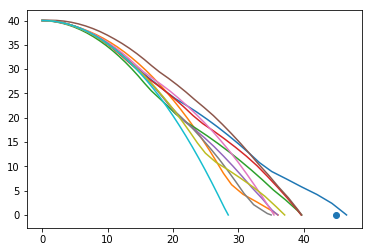

In [25]:
# initial flight

x_target = 45
w_effort = 1.0
w_target = 6.0
num_episodes = 10 # 10
max_step = 1000 # 10k
env = Glider(y_init = 40.0, target_x = x_target, delta_t = 0.01)
for episode in range(num_episodes):
    # if episode%1 == 0:
    #    print('Episode: ' + str(episode))
    # epsilon = get_epsilon(0.99, 0.1, episode, 10)
    Y, X, V = [], [], []
    episode_list = list()
    total_cost = 0.0
    state = env.reset()
    # state_disc = get_discrete_states(state_cont, all_state_arrays)
    effort_cost = 0.0
    for step in range(max_step):
        if step%1 == 0:
            action = random.choice(ACTIONS)
        # action = 0.0
        # cost, done = env.step(action)
        cost, done = env.probe_n_step(action, 10, True)
        new_state = env.get_state()
        total_cost += cost
        episode_list.append((state, action, cost))                
        state = new_state
        if done:
            state = env.get_state()
            episode_list.append((state, action, cost))
            break
        effort_cost += cost
    glider_landing_x = episode_list[len(episode_list)-1][0][0]
    target_cost = abs(target_x - glider_landing_x)
    total_cost = w_target*target_cost + w_effort*effort_cost
    
    # plot trajectory
    plot_trajectory(episode_list)
    plt.hold


plt.scatter(x_target,0)
plt.show()

In [23]:
# NFQ Reward main learning loop
# epsilon greedy determines which action to take during training.

ACTIONS = [-1.0, 0.0, 1.0]
num_input = 5 # 6
num_l1 = 20
num_l2 = 20
num_l3 = 20
num_l4 = 20
num_out = 1
W = {
    'h1':tf.Variable(tf.random_normal([num_input,num_l1])),
    'h2':tf.Variable(tf.random_normal([num_l1, num_l2])),
    'h3':tf.Variable(tf.random_normal([num_l2, num_l3])),
    'h4':tf.Variable(tf.random_normal([num_l3, num_l4])),
    'out':tf.Variable(tf.random_normal([num_l4, num_out]))
}    
b = {
    'b1':tf.Variable(tf.random_normal([num_l1])),
    'b2':tf.Variable(tf.random_normal([num_l2])),
    'b3':tf.Variable(tf.random_normal([num_l3])),
    'b4':tf.Variable(tf.random_normal([num_l4])),
    'out':tf.Variable(tf.random_normal([num_out]))
}

def multilayer_perceptron(x, W, b):        
    l1 = tf.add(tf.matmul(x, W['h1']), b['b1'])
    l1 = tf.nn.relu(l1)
    l2 = tf.add(tf.matmul(l1, W['h2']), b['b2'])
    l2 = tf.nn.relu(l2)
    l3 = tf.add(tf.matmul(l2, W['h3']), b['b3'])
    l3 = tf.nn.relu(l3)
    l4 = tf.add(tf.matmul(l3, W['h4']), b['b4'])
    l4 = tf.nn.relu(l4)
    out = tf.add(tf.matmul(l4, W['out']), b['out'])
    return out

# neural net

print('0')
sess = tf.Session()
x_Q_net = tf.placeholder("float", [None,num_input])
y_Q_net = tf.placeholder("float", [None,1])
Q_net = multilayer_perceptron(x_Q_net, W, b)
sess.run(tf.initialize_all_variables())
w_effort = 1.0
w_target = 2.0

target_x = 45.0
env = Glider(y_init = 40.0, target_x = x_target, delta_t=0.01)

"""
sess = tf.Session()
x = tf.placeholder("float", [None,num_input])
y = tf.placeholder("float", [None, 1]) # , name = 'y')   # 3 outputs
y_ = multilayer_perceptron(x, W, b)
sess.run(tf.initialize_all_variables())
"""
# loss = tf.losses.mean_squared_error(labels, predictions)
# train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

0
Instructions for updating:
Use `tf.global_variables_initializer` instead.


'\nsess = tf.Session()\nx = tf.placeholder("float", [None,num_input])\ny = tf.placeholder("float", [None, 1]) # , name = \'y\')   # 3 outputs\ny_ = multilayer_perceptron(x, W, b)\nsess.run(tf.initialize_all_variables())\n'

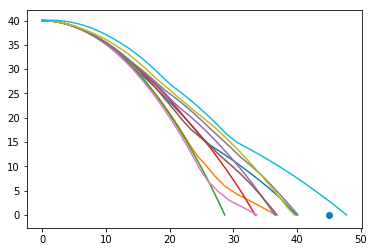

batch: 0, 	 epsilon: 0.33333333333333337
max reward: 5.00814352995, 	 max_target_reward: 4.55407176498, 	 max_control_reward: -4.1

training: 0/10000, 	 loss: 4.29091e+06, 	 normalized loss: 13325.8136646, 	 len(A): 322
training: 1000/10000, 	 loss: 1845.55, 	 normalized loss: 5.73152454447, 	 len(A): 322
training: 2000/10000, 	 loss: 998.976, 	 normalized loss: 3.10241130568, 	 len(A): 322
training: 3000/10000, 	 loss: 705.319, 	 normalized loss: 2.19043025615, 	 len(A): 322
training: 4000/10000, 	 loss: 557.775, 	 normalized loss: 1.73222019361, 	 len(A): 322
training: 5000/10000, 	 loss: 472.611, 	 normalized loss: 1.46773742297, 	 len(A): 322
training: 6000/10000, 	 loss: 407.567, 	 normalized loss: 1.26573512865, 	 len(A): 322
training: 7000/10000, 	 loss: 369.319, 	 normalized loss: 1.14695322736, 	 len(A): 322
training: 8000/10000, 	 loss: 340.607, 	 normalized loss: 1.05778607671, 	 len(A): 322
training: 9000/10000, 	 loss: 315.846, 	 normalized loss: 0.980887466336, 	 len(A): 

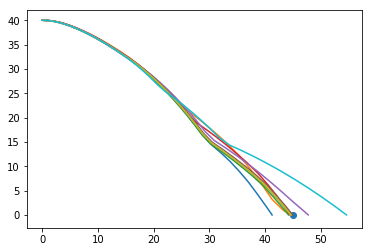

batch: 1, 	 epsilon: 0.9666666666666667
max reward: 15.6065620289, 	 max_target_reward: 9.99828101446, 	 max_control_reward: -4.39

training: 0/10000, 	 loss: 1156.45, 	 normalized loss: 1.74163744823, 	 len(A): 664
training: 1000/10000, 	 loss: 576.938, 	 normalized loss: 0.868881960949, 	 len(A): 664
training: 2000/10000, 	 loss: 432.191, 	 normalized loss: 0.650890166501, 	 len(A): 664
training: 3000/10000, 	 loss: 354.427, 	 normalized loss: 0.533775789192, 	 len(A): 664
training: 4000/10000, 	 loss: 295.054, 	 normalized loss: 0.444358641843, 	 len(A): 664
training: 5000/10000, 	 loss: 256.758, 	 normalized loss: 0.386683590441, 	 len(A): 664
training: 6000/10000, 	 loss: 232.238, 	 normalized loss: 0.349756401705, 	 len(A): 664
training: 7000/10000, 	 loss: 213.34, 	 normalized loss: 0.321294600705, 	 len(A): 664
training: 8000/10000, 	 loss: 199.462, 	 normalized loss: 0.300394747631, 	 len(A): 664
training: 9000/10000, 	 loss: 189.458, 	 normalized loss: 0.28532850886, 	 len(A)

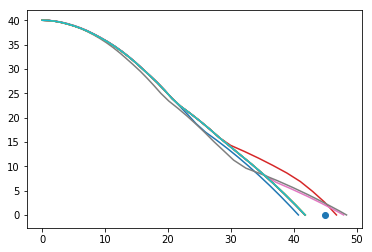

batch: 2, 	 epsilon: 0.9777777777777777
max reward: 7.8908901074, 	 max_target_reward: 6.5154450537, 	 max_control_reward: -5.14

training: 0/10000, 	 loss: 189.062, 	 normalized loss: 0.189061965942, 	 len(A): 1000
training: 1000/10000, 	 loss: 175.646, 	 normalized loss: 0.175645599365, 	 len(A): 1000
training: 2000/10000, 	 loss: 168.623, 	 normalized loss: 0.168622756958, 	 len(A): 1000
training: 3000/10000, 	 loss: 161.658, 	 normalized loss: 0.161658279419, 	 len(A): 1000
training: 4000/10000, 	 loss: 155.92, 	 normalized loss: 0.155919815063, 	 len(A): 1000
training: 5000/10000, 	 loss: 150.437, 	 normalized loss: 0.15043737793, 	 len(A): 1000
training: 6000/10000, 	 loss: 146.101, 	 normalized loss: 0.14610144043, 	 len(A): 1000
training: 7000/10000, 	 loss: 142.292, 	 normalized loss: 0.142291778564, 	 len(A): 1000
training: 8000/10000, 	 loss: 138.912, 	 normalized loss: 0.138912002563, 	 len(A): 1000
training: 9000/10000, 	 loss: 135.698, 	 normalized loss: 0.135698287964, 	

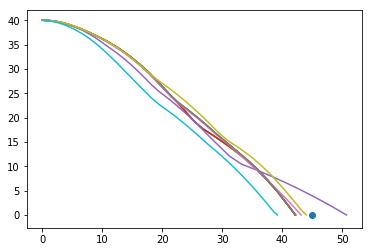

batch: 3, 	 epsilon: 0.9851851851851852
max reward: 11.8675688519, 	 max_target_reward: 8.01878442596, 	 max_control_reward: -4.17

training: 0/10000, 	 loss: 141.763, 	 normalized loss: 0.10618978779, 	 len(A): 1335
training: 1000/10000, 	 loss: 135.871, 	 normalized loss: 0.101776031608, 	 len(A): 1335
training: 2000/10000, 	 loss: 132.223, 	 normalized loss: 0.0990434625176, 	 len(A): 1335
training: 3000/10000, 	 loss: 129.018, 	 normalized loss: 0.0966423691882, 	 len(A): 1335
training: 4000/10000, 	 loss: 126.009, 	 normalized loss: 0.0943889317888, 	 len(A): 1335
training: 5000/10000, 	 loss: 123.368, 	 normalized loss: 0.0924103183246, 	 len(A): 1335
training: 6000/10000, 	 loss: 120.927, 	 normalized loss: 0.0905819096369, 	 len(A): 1335
training: 7000/10000, 	 loss: 118.703, 	 normalized loss: 0.0889159470462, 	 len(A): 1335
training: 8000/10000, 	 loss: 116.649, 	 normalized loss: 0.0873776382275, 	 len(A): 1335
training: 9000/10000, 	 loss: 114.723, 	 normalized loss: 0.0859

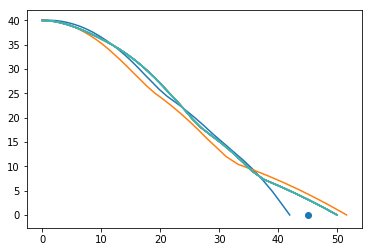

batch: 4, 	 epsilon: 0.9901234567901235
max reward: 3.21970160408, 	 max_target_reward: 3.86485080204, 	 max_control_reward: -4.51

training: 0/10000, 	 loss: 144.673, 	 normalized loss: 0.0859103893724, 	 len(A): 1684
training: 1000/10000, 	 loss: 133.169, 	 normalized loss: 0.0790787921099, 	 len(A): 1684
training: 2000/10000, 	 loss: 130.078, 	 normalized loss: 0.0772435784057, 	 len(A): 1684
training: 3000/10000, 	 loss: 127.573, 	 normalized loss: 0.0757556652513, 	 len(A): 1684
training: 4000/10000, 	 loss: 125.272, 	 normalized loss: 0.0743894599679, 	 len(A): 1684
training: 5000/10000, 	 loss: 123.318, 	 normalized loss: 0.0732291033602, 	 len(A): 1684
training: 6000/10000, 	 loss: 121.584, 	 normalized loss: 0.0721994567654, 	 len(A): 1684
training: 7000/10000, 	 loss: 119.987, 	 normalized loss: 0.0712510151988, 	 len(A): 1684
training: 8000/10000, 	 loss: 118.453, 	 normalized loss: 0.0703402041256, 	 len(A): 1684
training: 9000/10000, 	 loss: 116.965, 	 normalized loss: 0.0

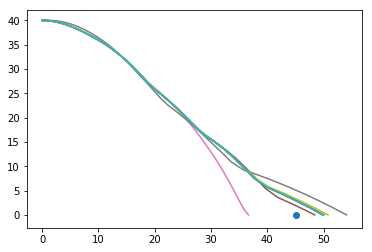

batch: 5, 	 epsilon: 0.9934156378600824
max reward: 2.54711564389, 	 max_target_reward: 3.19355782194, 	 max_control_reward: -3.8400000000000003

training: 0/10000, 	 loss: 130.283, 	 normalized loss: 0.0640840919746, 	 len(A): 2033
training: 1000/10000, 	 loss: 126.228, 	 normalized loss: 0.0620893486837, 	 len(A): 2033
training: 2000/10000, 	 loss: 124.462, 	 normalized loss: 0.0612210838066, 	 len(A): 2033
training: 3000/10000, 	 loss: 122.954, 	 normalized loss: 0.0604792274516, 	 len(A): 2033
training: 4000/10000, 	 loss: 121.586, 	 normalized loss: 0.0598059530863, 	 len(A): 2033
training: 5000/10000, 	 loss: 119.786, 	 normalized loss: 0.058920601818, 	 len(A): 2033
training: 6000/10000, 	 loss: 118.063, 	 normalized loss: 0.0580731348281, 	 len(A): 2033
training: 7000/10000, 	 loss: 116.537, 	 normalized loss: 0.0573225382567, 	 len(A): 2033
training: 8000/10000, 	 loss: 115.176, 	 normalized loss: 0.0566534069566, 	 len(A): 2033
training: 9000/10000, 	 loss: 113.917, 	 normali

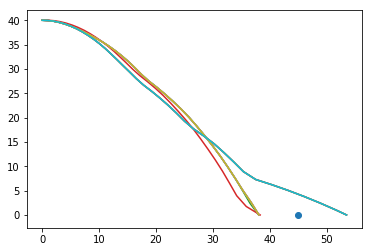

batch: 6, 	 epsilon: 0.9956104252400548
max reward: -10.3914530418, 	 max_target_reward: -3.34572652091, 	 max_control_reward: -3.6999999999999993

training: 0/10000, 	 loss: 138.018, 	 normalized loss: 0.0582354774958, 	 len(A): 2370
training: 1000/10000, 	 loss: 130.598, 	 normalized loss: 0.0551044641165, 	 len(A): 2370
training: 2000/10000, 	 loss: 127.589, 	 normalized loss: 0.053835048756, 	 len(A): 2370
training: 3000/10000, 	 loss: 125.352, 	 normalized loss: 0.052891218612, 	 len(A): 2370
training: 4000/10000, 	 loss: 123.463, 	 normalized loss: 0.0520942816754, 	 len(A): 2370
training: 5000/10000, 	 loss: 121.806, 	 normalized loss: 0.0513948915377, 	 len(A): 2370
training: 6000/10000, 	 loss: 120.315, 	 normalized loss: 0.0507656918296, 	 len(A): 2370
training: 7000/10000, 	 loss: 118.937, 	 normalized loss: 0.0501843223089, 	 len(A): 2370
training: 8000/10000, 	 loss: 117.639, 	 normalized loss: 0.0496368826693, 	 len(A): 2370
training: 9000/10000, 	 loss: 116.411, 	 normal

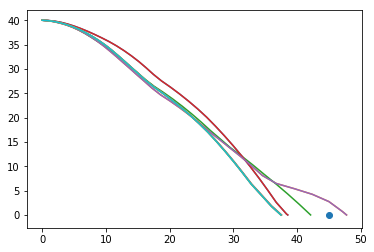

batch: 7, 	 epsilon: 0.9970736168267033
max reward: 4.05973370383, 	 max_target_reward: 4.52486685192, 	 max_control_reward: -4.989999999999999

training: 0/10000, 	 loss: 115.375, 	 normalized loss: 0.0427471837895, 	 len(A): 2699
training: 1000/10000, 	 loss: 112.969, 	 normalized loss: 0.0418558279732, 	 len(A): 2699
training: 2000/10000, 	 loss: 111.811, 	 normalized loss: 0.041426922578, 	 len(A): 2699
training: 3000/10000, 	 loss: 110.717, 	 normalized loss: 0.0410213915672, 	 len(A): 2699
training: 4000/10000, 	 loss: 109.659, 	 normalized loss: 0.0406296155152, 	 len(A): 2699
training: 5000/10000, 	 loss: 108.556, 	 normalized loss: 0.0402206528315, 	 len(A): 2699
training: 6000/10000, 	 loss: 107.25, 	 normalized loss: 0.0397369961422, 	 len(A): 2699
training: 7000/10000, 	 loss: 106.032, 	 normalized loss: 0.0392858385819, 	 len(A): 2699
training: 8000/10000, 	 loss: 104.933, 	 normalized loss: 0.0388783769017, 	 len(A): 2699
training: 9000/10000, 	 loss: 103.946, 	 normalize

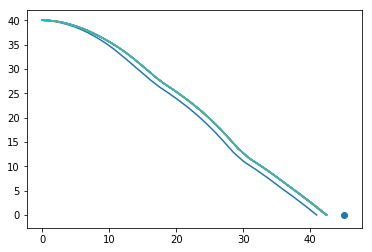

batch: 8, 	 epsilon: 0.9980490778844688
max reward: 5.84459254262, 	 max_target_reward: 4.86729627131, 	 max_control_reward: -3.89

training: 0/10000, 	 loss: 96.9844, 	 normalized loss: 0.0319237674515, 	 len(A): 3038
training: 1000/10000, 	 loss: 95.8777, 	 normalized loss: 0.0315594651183, 	 len(A): 3038
training: 2000/10000, 	 loss: 95.1473, 	 normalized loss: 0.031319048783, 	 len(A): 3038
training: 3000/10000, 	 loss: 94.2611, 	 normalized loss: 0.0310273638205, 	 len(A): 3038
training: 4000/10000, 	 loss: 93.3378, 	 normalized loss: 0.0307234210981, 	 len(A): 3038
training: 5000/10000, 	 loss: 92.3485, 	 normalized loss: 0.0303978081829, 	 len(A): 3038
training: 6000/10000, 	 loss: 90.8757, 	 normalized loss: 0.0299130026018, 	 len(A): 3038
training: 7000/10000, 	 loss: 88.1878, 	 normalized loss: 0.029028248991, 	 len(A): 3038
training: 8000/10000, 	 loss: 86.4393, 	 normalized loss: 0.0284526968096, 	 len(A): 3038
training: 9000/10000, 	 loss: 85.1951, 	 normalized loss: 0.028

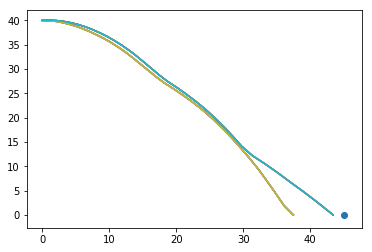

batch: 9, 	 epsilon: 0.9986993852563125
max reward: 9.65349934143, 	 max_target_reward: 6.83674967071, 	 max_control_reward: -4.02

training: 0/10000, 	 loss: 84.8257, 	 normalized loss: 0.0251857707733, 	 len(A): 3368
training: 1000/10000, 	 loss: 82.9237, 	 normalized loss: 0.0246210438056, 	 len(A): 3368
training: 2000/10000, 	 loss: 82.0269, 	 normalized loss: 0.0243547715937, 	 len(A): 3368
training: 3000/10000, 	 loss: 81.4519, 	 normalized loss: 0.02418405483, 	 len(A): 3368
training: 4000/10000, 	 loss: 80.9622, 	 normalized loss: 0.0240386614041, 	 len(A): 3368
training: 5000/10000, 	 loss: 80.495, 	 normalized loss: 0.0238999369026, 	 len(A): 3368
training: 6000/10000, 	 loss: 80.0038, 	 normalized loss: 0.0237540904247, 	 len(A): 3368
training: 7000/10000, 	 loss: 79.5027, 	 normalized loss: 0.0236053036398, 	 len(A): 3368
training: 8000/10000, 	 loss: 79.0782, 	 normalized loss: 0.0234792759186, 	 len(A): 3368
training: 9000/10000, 	 loss: 78.7113, 	 normalized loss: 0.0233

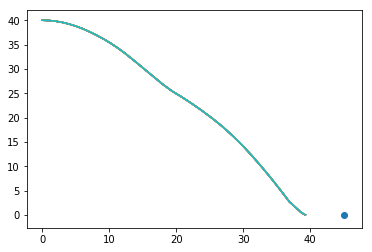

batch: 10, 	 epsilon: 0.9991329235042083
max reward: -6.33259075845, 	 max_target_reward: -1.49629537923, 	 max_control_reward: -3.34

training: 0/10000, 	 loss: 77.2065, 	 normalized loss: 0.0208779062175, 	 len(A): 3698
training: 1000/10000, 	 loss: 76.5646, 	 normalized loss: 0.0207043364604, 	 len(A): 3698
training: 2000/10000, 	 loss: 76.1043, 	 normalized loss: 0.0205798502417, 	 len(A): 3698
training: 3000/10000, 	 loss: 75.7083, 	 normalized loss: 0.0204727725766, 	 len(A): 3698
training: 4000/10000, 	 loss: 75.3631, 	 normalized loss: 0.0203794208071, 	 len(A): 3698
training: 5000/10000, 	 loss: 75.0272, 	 normalized loss: 0.0202885860363, 	 len(A): 3698
training: 6000/10000, 	 loss: 74.7114, 	 normalized loss: 0.0202031978857, 	 len(A): 3698
training: 7000/10000, 	 loss: 74.4103, 	 normalized loss: 0.0201217750397, 	 len(A): 3698
training: 8000/10000, 	 loss: 74.1038, 	 normalized loss: 0.0200388729411, 	 len(A): 3698
training: 9000/10000, 	 loss: 73.7696, 	 normalized loss: 

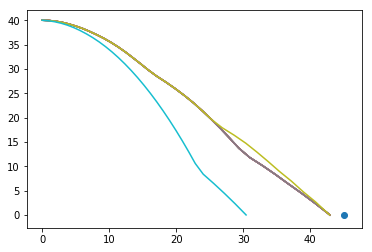

batch: 11, 	 epsilon: 0.9994219490028056
max reward: 8.4592807684, 	 max_target_reward: 5.8796403842, 	 max_control_reward: -3.2999999999999994

training: 0/10000, 	 loss: 71.2921, 	 normalized loss: 0.0176684184588, 	 len(A): 4035
training: 1000/10000, 	 loss: 70.9089, 	 normalized loss: 0.0175734660587, 	 len(A): 4035
training: 2000/10000, 	 loss: 70.6154, 	 normalized loss: 0.0175007173711, 	 len(A): 4035
training: 3000/10000, 	 loss: 70.3374, 	 normalized loss: 0.017431814579, 	 len(A): 4035
training: 4000/10000, 	 loss: 70.0458, 	 normalized loss: 0.017359542374, 	 len(A): 4035
training: 5000/10000, 	 loss: 69.6864, 	 normalized loss: 0.0172704836102, 	 len(A): 4035
training: 6000/10000, 	 loss: 69.2748, 	 normalized loss: 0.0171684747292, 	 len(A): 4035
training: 7000/10000, 	 loss: 68.8982, 	 normalized loss: 0.0170751503114, 	 len(A): 4035
training: 8000/10000, 	 loss: 68.5638, 	 normalized loss: 0.0169922669138, 	 len(A): 4035
training: 9000/10000, 	 loss: 68.2418, 	 normalize

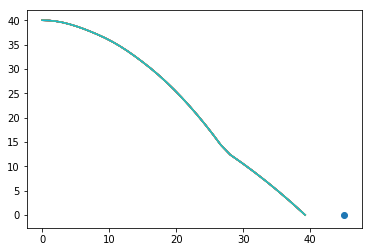

batch: 12, 	 epsilon: 0.999614632668537
max reward: -7.43070506024, 	 max_target_reward: -1.59035253012, 	 max_control_reward: -4.249999999999999

training: 0/10000, 	 loss: 69.4679, 	 normalized loss: 0.0159147491979, 	 len(A): 4365
training: 1000/10000, 	 loss: 68.8449, 	 normalized loss: 0.0157720349499, 	 len(A): 4365
training: 2000/10000, 	 loss: 68.4616, 	 normalized loss: 0.015684220881, 	 len(A): 4365
training: 3000/10000, 	 loss: 68.134, 	 normalized loss: 0.0156091731575, 	 len(A): 4365
training: 4000/10000, 	 loss: 67.8451, 	 normalized loss: 0.015542969589, 	 len(A): 4365
training: 5000/10000, 	 loss: 67.585, 	 normalized loss: 0.0154833799102, 	 len(A): 4365
training: 6000/10000, 	 loss: 67.3423, 	 normalized loss: 0.0154277893276, 	 len(A): 4365
training: 7000/10000, 	 loss: 67.1037, 	 normalized loss: 0.0153731198655, 	 len(A): 4365
training: 8000/10000, 	 loss: 66.8633, 	 normalized loss: 0.0153180623792, 	 len(A): 4365
training: 9000/10000, 	 loss: 66.6326, 	 normalize

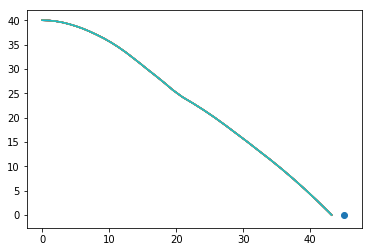

batch: 13, 	 epsilon: 0.9997430884456914
max reward: 8.44327587944, 	 max_target_reward: 6.39663793972, 	 max_control_reward: -4.349999999999999

training: 0/10000, 	 loss: 64.3396, 	 normalized loss: 0.0136747370364, 	 len(A): 4705
training: 1000/10000, 	 loss: 64.1098, 	 normalized loss: 0.0136258862097, 	 len(A): 4705
training: 2000/10000, 	 loss: 63.9041, 	 normalized loss: 0.01358216759, 	 len(A): 4705
training: 3000/10000, 	 loss: 63.7002, 	 normalized loss: 0.0135388251699, 	 len(A): 4705
training: 4000/10000, 	 loss: 63.5035, 	 normalized loss: 0.0134970159257, 	 len(A): 4705
training: 5000/10000, 	 loss: 63.3143, 	 normalized loss: 0.0134568047194, 	 len(A): 4705
training: 6000/10000, 	 loss: 63.1304, 	 normalized loss: 0.0134177318415, 	 len(A): 4705
training: 7000/10000, 	 loss: 62.9521, 	 normalized loss: 0.0133798378307, 	 len(A): 4705
training: 8000/10000, 	 loss: 62.7775, 	 normalized loss: 0.0133427156779, 	 len(A): 4705
training: 9000/10000, 	 loss: 62.6077, 	 normaliz

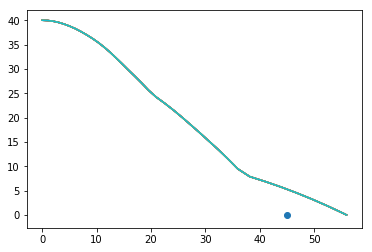

batch: 14, 	 epsilon: 0.9998287256304609
max reward: -28.9933592987, 	 max_target_reward: -11.8266796494, 	 max_control_reward: -5.339999999999999

training: 0/10000, 	 loss: 89.1057, 	 normalized loss: 0.0175577744357, 	 len(A): 5075
training: 1000/10000, 	 loss: 84.7641, 	 normalized loss: 0.0167022825344, 	 len(A): 5075
training: 2000/10000, 	 loss: 83.2678, 	 normalized loss: 0.0164074541665, 	 len(A): 5075
training: 3000/10000, 	 loss: 82.2803, 	 normalized loss: 0.0162128767944, 	 len(A): 5075
training: 4000/10000, 	 loss: 81.4474, 	 normalized loss: 0.0160487523572, 	 len(A): 5075
training: 5000/10000, 	 loss: 80.6396, 	 normalized loss: 0.0158895843957, 	 len(A): 5075
training: 6000/10000, 	 loss: 79.9946, 	 normalized loss: 0.0157624914611, 	 len(A): 5075
training: 7000/10000, 	 loss: 79.4307, 	 normalized loss: 0.0156513774101, 	 len(A): 5075
training: 8000/10000, 	 loss: 78.9419, 	 normalized loss: 0.0155550531096, 	 len(A): 5075
training: 9000/10000, 	 loss: 78.4035, 	 norm

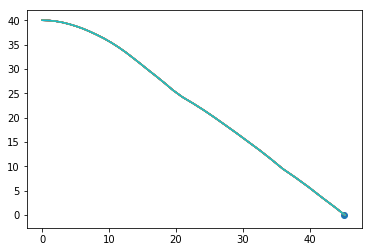

batch: 15, 	 epsilon: 0.999885817086974
max reward: 15.2303854543, 	 max_target_reward: 9.64519272715, 	 max_control_reward: -4.059999999999999

training: 0/10000, 	 loss: 76.8363, 	 normalized loss: 0.0141895241354, 	 len(A): 5415
training: 1000/10000, 	 loss: 76.3582, 	 normalized loss: 0.0141012359084, 	 len(A): 5415
training: 2000/10000, 	 loss: 76.0544, 	 normalized loss: 0.0140451418946, 	 len(A): 5415
training: 3000/10000, 	 loss: 75.7863, 	 normalized loss: 0.0139956276172, 	 len(A): 5415
training: 4000/10000, 	 loss: 75.5351, 	 normalized loss: 0.0139492397713, 	 len(A): 5415
training: 5000/10000, 	 loss: 75.2951, 	 normalized loss: 0.0139049089736, 	 len(A): 5415
training: 6000/10000, 	 loss: 75.0603, 	 normalized loss: 0.0138615447068, 	 len(A): 5415
training: 7000/10000, 	 loss: 74.8278, 	 normalized loss: 0.0138186143926, 	 len(A): 5415
training: 8000/10000, 	 loss: 74.5991, 	 normalized loss: 0.0137763829112, 	 len(A): 5415
training: 9000/10000, 	 loss: 74.384, 	 normaliz

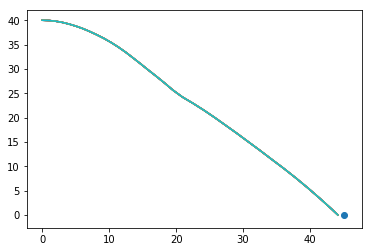

batch: 16, 	 epsilon: 0.9999238780579827
max reward: 12.2203723632, 	 max_target_reward: 8.28018618162, 	 max_control_reward: -4.339999999999999

training: 0/10000, 	 loss: 72.1915, 	 normalized loss: 0.0125441364782, 	 len(A): 5755
training: 1000/10000, 	 loss: 71.9522, 	 normalized loss: 0.0125025479924, 	 len(A): 5755
training: 2000/10000, 	 loss: 71.7722, 	 normalized loss: 0.0124712787433, 	 len(A): 5755
training: 3000/10000, 	 loss: 71.6006, 	 normalized loss: 0.0124414531797, 	 len(A): 5755
training: 4000/10000, 	 loss: 71.4347, 	 normalized loss: 0.0124126324956, 	 len(A): 5755
training: 5000/10000, 	 loss: 71.2743, 	 normalized loss: 0.0123847530574, 	 len(A): 5755
training: 6000/10000, 	 loss: 71.1229, 	 normalized loss: 0.0123584538517, 	 len(A): 5755
training: 7000/10000, 	 loss: 70.9764, 	 normalized loss: 0.0123329991159, 	 len(A): 5755


KeyboardInterrupt: 

In [24]:
num_batch = 100
num_episodes = 10 # 10
max_step = 1000 # 10k
effort_scale = 1.0
n_steps = 10
optimal_total_reward = -1e9
A_end = []
B_end = []
A = []
B = []
for batch in range(num_batch):
    episode_max_reward = -1e9
    episode_max_target_reward = -1e9
    episode_max_effort_reward = -1e9
    for episode in range(num_episodes):
        # if episode%10 == 0:
        #    print('Episode: ' + str(episode))
        Y, X, V = [], [], []
        episode_list = list()
        total_cost = 0.0
        total_reward = 0.0
        state = env.reset()
        effort_reward = 0.0
        effort_cost = 0.0
        num_control_effort = 0.0
        for step in range(max_step):
            state_action_1 = env.probe_step(1.0)
            state_action_0 = env.probe_step(0.0)
            state_action_minus_1 = env.probe_step(-1.0)
            
            state_action_1 = env.probe_n_step(1.0, n_steps, False)
            state_action_0 = env.probe_n_step(0.0, n_steps, False)
            state_action_minus_1 = env.probe_n_step(-1.0, n_steps, False)
            
            state_action_1 = state_action_1[0:5]
            state_action_0 = state_action_0[0:5]
            state_action_minus_1 = state_action_minus_1[0:5]            
            
            Q_1 = sess.run(Q_net, {x_Q_net : [state_action_1,]})
            Q_0 = sess.run(Q_net, {x_Q_net : [state_action_0,]})
            Q_m1 = sess.run(Q_net, {x_Q_net : [state_action_minus_1,]})
                        
            max_Q_index = np.argmax([Q_m1, Q_0 - 0.01*step, Q_1])   
            action_opt = ACTIONS[max_Q_index]            
            
            actions_ind0 = copy.deepcopy(ACTIONS[0])
            tot_actions = copy.deepcopy(ACTIONS)
            tot_actions[0] = action_opt
            tot_actions[max_Q_index] = actions_ind0
            weight_array = [0.5, 0.25, 0.25]
            if batch == 0:
                w_opt = min(1 - 2.0/3.0/(1.0+0.1*batch), 1) # /(1.0+0.01*step)
            else:
                w_opt = 1.0 - 0.05/(1.5**batch) # min(1 - 0.05/(batch), 1)           
            weight_array = [w_opt, (1.0-w_opt)/2, (1.0-w_opt)/2]
            if step%1 == 0:
                action = np.random.choice(tot_actions, 1, p=weight_array)[0]
            if action != 0:
                num_control_effort += 1.0        
            cost, done = env.probe_n_step(action, 10, True)
            if cost == 0.0:
                reward = 0.0
            else:
                reward = -0.01*step*w_effort/effort_scale
            new_state = env.get_state()
            total_cost += cost
            episode_list.append((state, action, reward))                
            state = new_state
            if done:
                state = env.get_state()
                episode_list.append((state, action, cost))
                break
            effort_reward += reward
            effort_cost += cost                

        effort_cost = effort_cost/effort_scale
        glider_landing_x = episode_list[len(episode_list)-1][0][0]
        target_cost = abs(target_x - glider_landing_x)
        target_reward = 10.0 - 2*abs(target_x - glider_landing_x)
        total_cost = w_target*target_cost + w_effort*effort_cost
        total_reward = w_target*target_reward + w_effort*effort_reward

        if total_reward > episode_max_reward:
            episode_max_reward = total_reward
            episode_max_target_reward = target_reward
            episode_max_effort_reward = effort_reward
        
        if total_reward > optimal_total_reward:
            # print('new max')
            optimal_total_reward = total_reward
            optimal_episode_list = episode_list                     
        
        A_episode, B_episode = training_data_inv(episode_list, total_reward, w_effort, effort_scale)
        A.extend(A_episode)
        B.extend(B_episode)
        
        plot_trajectory(episode_list)
        plt.hold
    plt.scatter(x_target,0)
    plt.show()
    
    A_opt_episode, B_opt_episode = training_data_inv(optimal_episode_list, optimal_total_reward, w_effort, effort_scale)

    loss = tf.losses.mean_squared_error(y_Q_net, Q_net)
    if batch == 0:
        training_rate = 1e-8
    
    train_step = tf.train.GradientDescentOptimizer(training_rate).minimize(loss)    
    
    print('batch: ' + str(batch) + ', \t epsilon: ' + str(w_opt))
    print('max reward: ' + str(episode_max_reward) + ', \t max_target_reward: ' + str(episode_max_target_reward) + ', \t max_control_reward: ' + str(episode_max_effort_reward) + '\n')

    # train MLP  
    num_train = 10000
    for j in range(num_train):
        _, loss_value = sess.run([train_step, loss], feed_dict={x_Q_net:A, y_Q_net:B})
        if j%1000 == 0:
            print('training: ' + str(j) + '/' + str(num_train) + ', \t loss: ' + str(loss_value) + ', \t normalized loss: ' + str(loss_value/len(A)) + ', \t len(A): ' + str(len(A)))

In [26]:
random.rand

AttributeError: module 'random' has no attribute 'rand'